In [1]:
# import libraries
import numpy as np
import pandas as pd
import os 

import math

from arch import arch_model
from scipy import stats

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats as sm_stat

In [2]:
#%% Define Functions

def tsdisplay(y, figsize = (14, 8), title = "", lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Time\ Series\ " + title + "$", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40, density = 1)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.show()



def tsdiag(y, figsize = (14,8), title = "", lags = 10):
    #The data:
    tmp_data = pd.Series(y)
    #The Ljung-Box test results for the first k lags:
    tmp_acor = sm_stat.diagnostic.acorr_ljungbox(tmp_data, lags = lags, boxpierce = True)
    # get the p-values
    p_vals = pd.Series(tmp_acor['lb_pvalue'])
    #Start the index from 1 instead of 0 (because Ljung-Box test is for lag values from 1 to k)
    p_vals.index += 1
    fig = plt.figure(figsize = figsize)
    #Plot the p-values:
    p_vals.plot(ax = fig.add_subplot(313), linestyle='', marker='o', title = "p-values for Ljung-Box statistic", legend = False)
    #Add the horizontal 0.05 critical value line
    plt.axhline(y = 0.05, color = 'blue', linestyle='--')
    # Annotate the p-value points above and to the left of the vertex
    x = np.arange(p_vals.size) + 1
    for X, Y, Z in zip(x, p_vals, p_vals):
        plt.annotate(round(Z, 4), xy=(X,Y), xytext=(-5, 5), ha = 'left', textcoords='offset points')
    plt.show()
    # Return the statistics:
    # col_index = ["Ljung-Box: X-squared", "Ljung-Box: p-value", "Box-Pierce: X-squared", "Box-Pierce: p-value"]
    # return pd.DataFrame(tmp_acor, index = col_index, columns = range(1, len(tmp_acor[0]) + 1))

In [3]:
# Set up folder with data:
os.chdir('D:\\00_PROJECTS_sripts_code\\Zmiennosc')

In [34]:
##########################################################
##########################################################
#%% Read data
##########################################################
##########################################################

In [4]:
# Read Analysis Data:
df_raw = pd.read_csv('bitcoin_daily.csv')

In [5]:
##########################################################
##########################################################
#%% Prepare data
##########################################################
##########################################################

In [6]:
df = df_raw\
        .assign(Date = lambda x: x['Date'].astype('datetime64[ns]') )\
        .dropna(subset=['Date'])\
        .sort_values('Date')\
        .set_index('Date')

df = df.dropna()

In [7]:
# check na
df.asfreq('d').isna().sum()

close    0
dtype: int64

In [8]:
# Calculate daily returns as percentage price changes
df['Return'] = 100 * (df[['close']].pct_change())
df.dropna(subset = ['Return'], inplace = True)

df['Variance'] = df['Return'].sub(df['Return'].mean()).pow(2)

print(df)

               close    Return   Variance
Date                                     
2017-08-18   4119.42 -4.816897  24.818745
2017-08-19   4139.98  0.499099   0.111659
2017-08-20   4124.44 -0.375364   0.291934
2017-08-21   4016.00 -2.629205   7.807274
2017-08-22   3977.39 -0.961404   1.268662
...              ...       ...        ...
2023-08-04  29068.24 -0.463061   0.394392
2023-08-05  29083.08  0.051052   0.012971
2023-08-06  29094.01  0.037582   0.016221
2023-08-07  29177.38  0.286554   0.014789
2023-08-08  29894.66  2.458343   5.259675

[2182 rows x 3 columns]


In [9]:
#%% Daily volatility as the standard deviation of price returns:
std_daily = round(df['Return'].std(), 2)

print('Daily volatility: ', '{:.2f}%'.format(std_daily))

Daily volatility:  3.89%


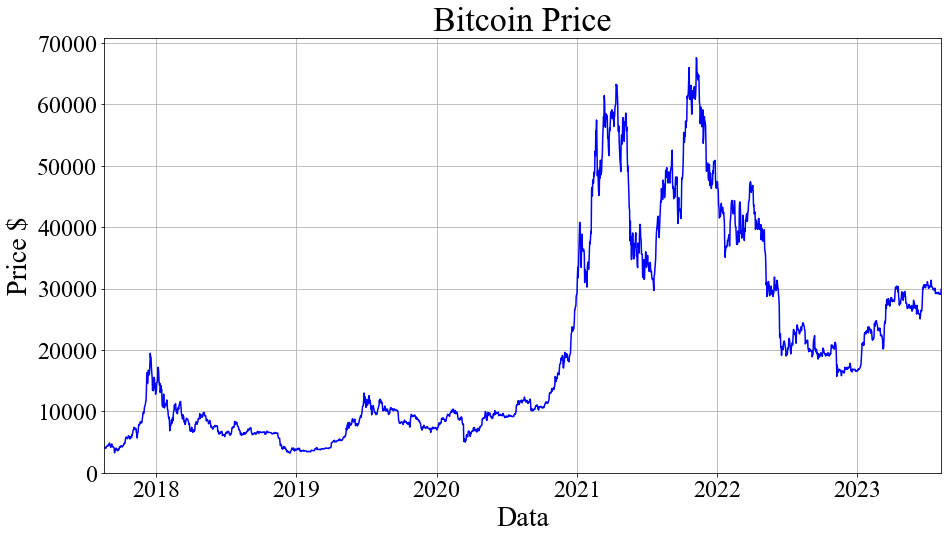

In [37]:
# Price Plot
fig = plt.figure(figsize=(15, 8))
plt.plot(df['close'], color = 'blue', label = 'Daily Returns')
plt.xlim(df.index[0], df.index[-1])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.xlabel('Data', fontsize=28)
plt.ylabel('Price $', fontsize=28)
plt.title('Bitcoin Price', fontsize=34)
plt.grid(True)
plt.show()

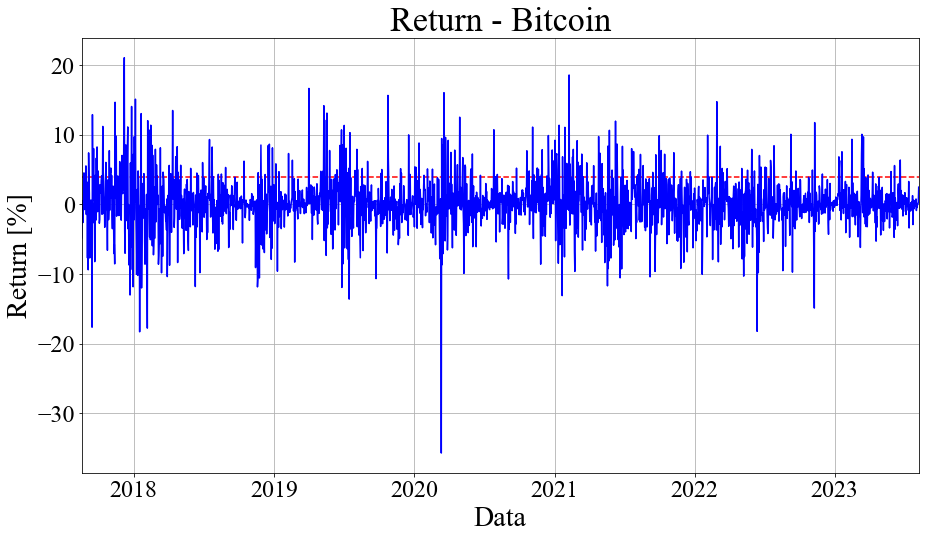

In [38]:
# Return Plot
fig = plt.figure(figsize=(15, 8))
plt.plot(df['Return'], color = 'blue', label = 'Daily Returns')
plt.xlim(df.index[0], df.index[-1])
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.xlabel('Data', fontsize=28)
plt.ylabel('Return [%]', fontsize=28)
plt.title('Return - Bitcoin', fontsize=34)
plt.hlines(y = std_daily, xmin = df.index[0], xmax = df.index[-1], colors='red', linestyles='dashed')

plt.grid(True)
plt.show()

In [12]:
##########################################################
##########################################################
#%% Check ARCH effects
##########################################################
##########################################################

In [13]:
# arch test - check autocorelation of r_t and r_t **2
# 
# If the squared residuals/errors (regresed on mean) of your time series model exhibit autocorrelation,
# then ARCH effects are present (but no in residual series)
# in our case return series becouse mean = 0

C:\Users\kamil\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


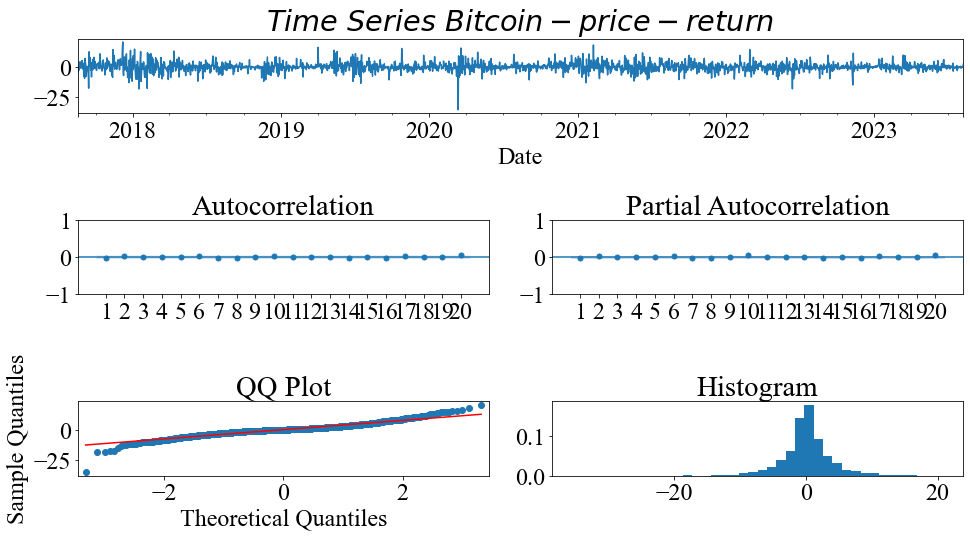

In [14]:
tsdisplay(df['Return'], title = "Bitcoin-price-return")

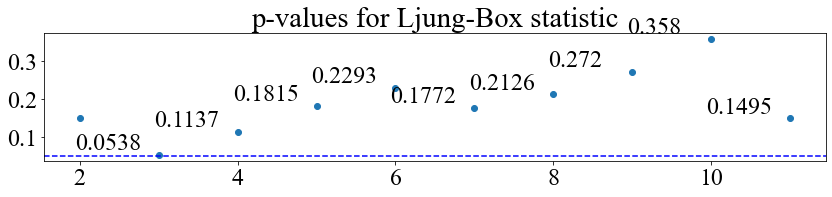

In [15]:
tsdiag(df['Return'])

C:\Users\kamil\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


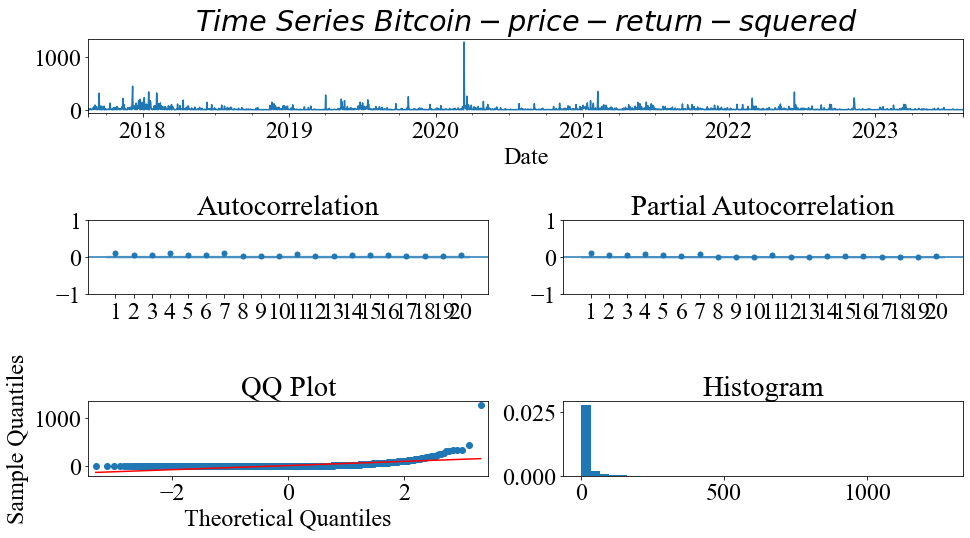

In [29]:
tsdisplay( df['Return']**2, title = "Bitcoin-price-return - squered")

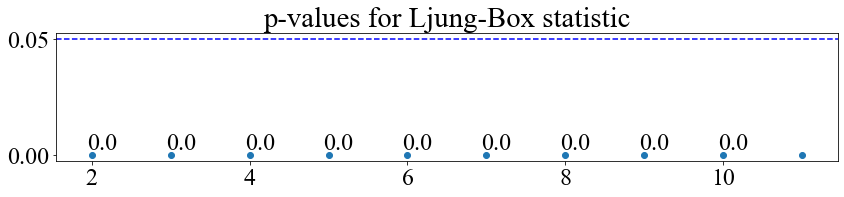

In [17]:
tsdiag(df['Return']**2)

In [18]:
# based on autocrelation plots and Ljung-Box test, we can clonclude then 'return' series is without autocorrelation,
# but 'squered' series is autocorrelated, so 'arch' effect exist in series

In [19]:
##########################################################
##########################################################
#%%  GARCH - fit model on whole dataset
##########################################################
##########################################################

In [20]:
# Specify GARCH model with t-student disribution (dist: 'normal', 't', 'skewt')
GarchModel = arch_model(df['Return'], p = 1, q = 1, o = 1, power = 1.0,\
                        mean = 'constant', vol = 'GARCH', dist = 't')

In [21]:
# FIT
gm_result = GarchModel.fit(update_freq=5, disp = 'off')
# print(gm_result.summary())

In [22]:
# CREATE DataFrame with Extracted data
Fitted__DF = df[['Return']].rename(columns = {'Return':'r_t'})
Fitted__DF['r_t__Fitted'] =  df['Return'] - gm_result.resid
Fitted__DF['sigma'] = gm_result.conditional_volatility
Fitted__DF['r_t_Fit__+__sigma'] = Fitted__DF['r_t__Fitted'] + 1 *Fitted__DF['sigma']
Fitted__DF['r_t_Fit__-__sigma'] = Fitted__DF['r_t__Fitted'] - 1 *Fitted__DF['sigma']
Fitted__DF['r_t_Fit__+__2_sigma'] = Fitted__DF['r_t__Fitted'] + 2 *Fitted__DF['sigma']
Fitted__DF['r_t_Fit__-__2_sigma'] = Fitted__DF['r_t__Fitted'] - 2 *Fitted__DF['sigma']

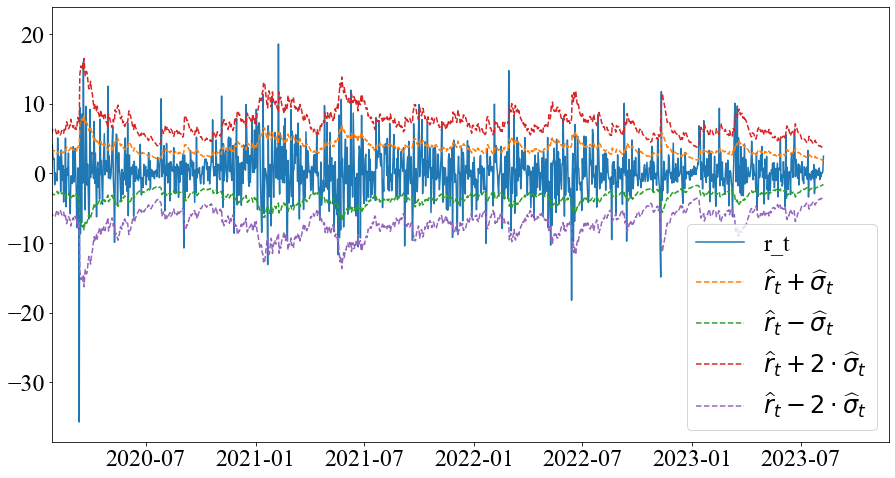

In [23]:
###  PLOT FITTED DATA
plt.figure(figsize=(15, 8))
plt.plot(Fitted__DF['r_t'], label = "r_t")
plt.plot(Fitted__DF['r_t_Fit__+__sigma'] , linestyle ="--", label = "$\widehat{r}_t +  \widehat{\sigma}_t$")
plt.plot(Fitted__DF['r_t_Fit__-__sigma'], linestyle ="--", label = "$\widehat{r}_t - \widehat{\sigma}_t$")
plt.plot(Fitted__DF['r_t_Fit__+__2_sigma'] , linestyle ="--", label = "$\widehat{r}_t + 2 \cdot \widehat{\sigma}_t$")
plt.plot(Fitted__DF['r_t_Fit__-__2_sigma'], linestyle ="--", label = "$\widehat{r}_t - 2 \cdot \widehat{\sigma}_t$")
# Custom start and end for the x-axis
#plt.xlim(360, len(r_t))
plt.xlim(datetime.date(2020, 1, 26))

# Custom start for the y-axis
#plt.ylim(-5)
plt.legend()
plt.show()

In [24]:
##########################################################
##########################################################
#%%  GARCH - Forceast
##########################################################
##########################################################

In [25]:
# Make forecast
forecast_horizon = 1

# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = forecast_horizon, reindex = False)

# Print the forecast variance
# print(gm_forecast.variance[-1:])

# CREATE DataFrame With Forecast

# Crate Forecast Date Range 
forecast_dates_gm = pd.date_range(Fitted__DF.index.tolist()[-1], periods=forecast_horizon+1, freq='d')[1:]
# Create Forecast DateFrame
Forecast_DF = pd.DataFrame( index = forecast_dates_gm)


## Add Mean     
Forecast_DF['r_t__Forecast'] = gm_forecast.mean.values.T
## Add Varaince
Forecast_DF['Forcast_Variance'] = gm_forecast.variance.values.T
Forecast_DF['Forcast_Residual_variance'] = gm_forecast.residual_variance.values.T

## Add sigma
Forecast_DF['sigma__Forecast'] = np.sqrt( Forecast_DF['Forcast_Variance'] )


Forecast_DF['r_t_For__+__sigma'] = Forecast_DF['r_t__Forecast'] + 1 *Forecast_DF['sigma__Forecast']
Forecast_DF['r_t_For__-__sigma'] = Forecast_DF['r_t__Forecast'] - 1 *Forecast_DF['sigma__Forecast']
Forecast_DF['r_t_For__+__2_sigma'] = Forecast_DF['r_t__Forecast'] + 2 *Forecast_DF['sigma__Forecast']
Forecast_DF['r_t_For__-__2_sigma'] = Forecast_DF['r_t__Forecast'] - 2 *Forecast_DF['sigma__Forecast']


Forecast_DF = Forecast_DF.round(1)

Text(0.5, 1.0, 'Returns, $r_t$')

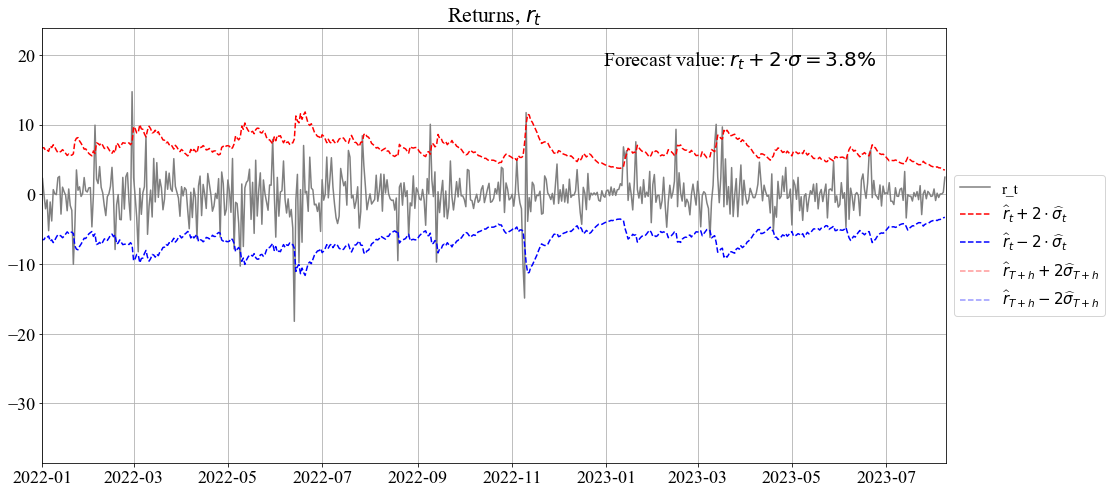

In [32]:
# PLOT FORECAST AND FITTED 
StartPlotDate = '2022-01-01'
Forecast_value = Forecast_DF["r_t_For__+__2_sigma"][0].round(1)


#fig = plt.figure()

fig, ax = plt.subplots(figsize=(18, 8))

plt.plot(Fitted__DF['r_t'], color = 'grey', label = "r_t")
plt.plot(Fitted__DF['r_t_Fit__+__2_sigma'], color = 'red' , linestyle ="--", label = "$\widehat{r}_t + 2 \cdot \widehat{\sigma}_t$")
plt.plot(Fitted__DF['r_t_Fit__-__2_sigma'], color = 'blue', linestyle ="--", label = "$\widehat{r}_t - 2 \cdot \widehat{\sigma}_t$")
plt.plot(Forecast_DF['r_t_For__+__2_sigma'], color = 'red', alpha = 0.4, linestyle = "--", label = "$\widehat{r}_{T+h} + 2 \widehat{\sigma}_{T+h}$")
plt.plot(Forecast_DF['r_t_For__-__2_sigma'], color = 'blue', alpha = 0.4, linestyle = "--", label = "$\widehat{r}_{T+h} - 2 \widehat{\sigma}_{T+h}$")
# plt.fill_between(Forecast_DF['r_t_For__+__2_sigma'], Forecast_DF['r_t_For__-__2_sigma'], color = "lightblue",alpha = 0.9)
#
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

plt.xlim( pd.to_datetime(StartPlotDate), Forecast_DF.index.values[-1])
plt.grid(True)

plt.text(0.62, 0.9, f'Forecast value: $ r_t +2 \dot \sigma = {Forecast_value} \% $', fontsize=20, transform=plt.gca().transAxes,
         ha='left', va='bottom')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
            fontsize='small', ncol=1)


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

plt.title("Returns, $r_t$")